<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_2_Sunspots_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Predicting Sunspots with Neural Networks (DNN only)

In the remaining labs for this week, you will move away from synthetic time series and start building models for real world data. In particular, you will train on the [Sunspots](https://www.kaggle.com/datasets/robervalt/sunspots) dataset: a monthly record of sunspot numbers from January 1749 to July 2018. You will first build a deep neural network here composed of dense layers. This will act as your baseline so you can compare it to the next lab where you will use a more complex architecture.

Let's begin!

## Imports

You will use the same imports as before with the addition of the [csv](https://docs.python.org/3/library/csv.html) module. You will need this to parse the CSV file containing the dataset.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

## Utilities

You will only have the `plot_series()` dataset here because you no longer need the synthetic data generation functions.

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Download and Preview the Dataset

You can now download the dataset and inspect the contents. The link in class is from Laurence's repo but we also hosted it in the link below.

In [9]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2024-07-11 10:24:29--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.74.123, 142.250.74.155, 142.250.74.187, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.74.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69,17K  --.-KB/s    in 0,1s    

2024-07-11 10:24:30 (651 KB/s) - ‘Sunspots.csv’ saved [70827/70827]



Running the cell below, you'll see that there are only three columns in the dataset:
1. untitled column containing the month number
2. Date which has the format `YYYY-MM-DD`
3. Mean Total Sunspot Number

In [10]:
# Preview the dataset
!head Sunspots.csv

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
5,1749-06-30,139.2
6,1749-07-31,158.0
7,1749-08-31,110.5
8,1749-09-30,126.5


For this lab and the next, you will only need the month number and the mean total sunspot number. You will load those into memory and convert it to arrays that represents a time series.

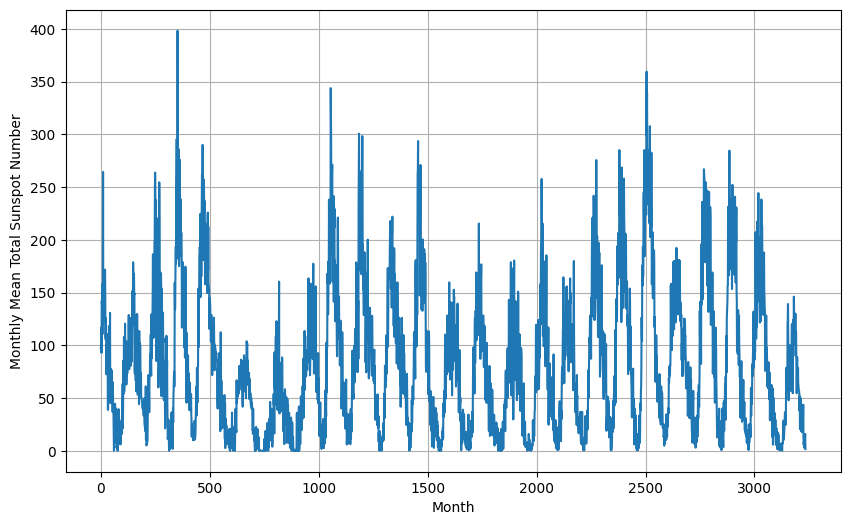

In [11]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./Sunspots.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

In [12]:
len(series)

3235

## Split the Dataset

Next, you will split the dataset into training and validation sets. There are 3235 points in the dataset and you will use the first 3000 for training.

In [13]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

You can then prepare the dataset windows as before. The window size is set to 30 points (equal to 2.5 years) but feel free to change later on if you want to experiment.

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [15]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

The model will be 3-layer dense network as shown below.

In [16]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

/Users/civye1/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,251 (4.89 KB)

 Trainable params: 1,251 (4.89 KB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

You can pick a learning rate by running the same learning rate scheduler code from previous labs.

In [17]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 119.5316 - learning_rate: 1.0000e-08
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 120.8713 - learning_rate: 1.1220e-08
Epoch 3/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 101.9615

2024-07-11 15:36:58.160530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/civye1/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-07-11 15:36:58.278462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 120.5595 - learning_rate: 1.2589e-08
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 120.1938 - learning_rate: 1.4125e-08
Epoch 5/100
54/93 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 117.3397

2024-07-11 15:36:58.380615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:36:58.483982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 118.5209 - learning_rate: 1.5849e-08
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 114.9832 - learning_rate: 1.7783e-08
Epoch 7/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 115.5670

2024-07-11 15:36:58.585708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:36:58.688290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 116.6109 - learning_rate: 1.9953e-08
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 110.1248 - learning_rate: 2.2387e-08
Epoch 9/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 107.5139

2024-07-11 15:36:58.793001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:36:58.896299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 110.0735 - learning_rate: 2.5119e-08
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 110.9991 - learning_rate: 2.8184e-08
Epoch 11/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 106.2974

2024-07-11 15:36:58.999219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:36:59.103489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 108.0193 - learning_rate: 3.1623e-08
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 104.7141 - learning_rate: 3.5481e-08
Epoch 13/100
54/93 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 100.8182

2024-07-11 15:36:59.207268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:36:59.308901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 102.6902 - learning_rate: 3.9811e-08
Epoch 14/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 102.5495 - learning_rate: 4.4668e-08
Epoch 15/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 98.0413

2024-07-11 15:36:59.411226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:36:59.515967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 98.6897 - learning_rate: 5.0119e-08
Epoch 16/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 95.6594 - learning_rate: 5.6234e-08
Epoch 17/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 89.1700

2024-07-11 15:36:59.618950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:36:59.721367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 90.7178 - learning_rate: 6.3096e-08
Epoch 18/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 88.2207 - learning_rate: 7.0795e-08
Epoch 19/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 82.3354

2024-07-11 15:36:59.824176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:36:59.926993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 84.4044 - learning_rate: 7.9433e-08
Epoch 20/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 77.6441 - learning_rate: 8.9125e-08
Epoch 21/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 75.6367

2024-07-11 15:37:00.030626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:00.131701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 76.7805 - learning_rate: 1.0000e-07
Epoch 22/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 74.7384 - learning_rate: 1.1220e-07
Epoch 23/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 68.0858

2024-07-11 15:37:00.234294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:00.336147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 68.3196 - learning_rate: 1.2589e-07
Epoch 24/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 63.9541 - learning_rate: 1.4125e-07
Epoch 25/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 57.3177

2024-07-11 15:37:00.438477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:00.541375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 58.4382 - learning_rate: 1.5849e-07
Epoch 26/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 55.1189 - learning_rate: 1.7783e-07
Epoch 27/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 48.2533

2024-07-11 15:37:00.643763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:00.778181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 48.9381 - learning_rate: 1.9953e-07
Epoch 28/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 45.8121 - learning_rate: 2.2387e-07
Epoch 29/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 41.6979

2024-07-11 15:37:00.881999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:00.987048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 42.1027 - learning_rate: 2.5119e-07
Epoch 30/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 39.9392 - learning_rate: 2.8184e-07
Epoch 31/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 37.4649

2024-07-11 15:37:01.089631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:01.190974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 37.6818 - learning_rate: 3.1623e-07
Epoch 32/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 34.8965 - learning_rate: 3.5481e-07
Epoch 33/100
54/93 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 33.0013

2024-07-11 15:37:01.293860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:01.395459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 33.7970 - learning_rate: 3.9811e-07
Epoch 34/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 32.0210 - learning_rate: 4.4668e-07
Epoch 35/100
52/93 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 29.1003

2024-07-11 15:37:01.496703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:01.598636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 30.2267 - learning_rate: 5.0119e-07
Epoch 36/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 29.9950 - learning_rate: 5.6234e-07
Epoch 37/100
52/93 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 27.1600

2024-07-11 15:37:01.701822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:01.806111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 27.8759 - learning_rate: 6.3096e-07
Epoch 38/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 26.9770 - learning_rate: 7.0795e-07
Epoch 39/100
54/93 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 25.3989

2024-07-11 15:37:01.909851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:02.012350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 25.7750 - learning_rate: 7.9433e-07
Epoch 40/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 25.2698 - learning_rate: 8.9125e-07
Epoch 41/100
51/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23.4699 

2024-07-11 15:37:02.117137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:02.227185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 23.7634 - learning_rate: 1.0000e-06
Epoch 42/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 23.5928 - learning_rate: 1.1220e-06
Epoch 43/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 22.5928

2024-07-11 15:37:02.332226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:02.435212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 22.8430 - learning_rate: 1.2589e-06
Epoch 44/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 22.1019 - learning_rate: 1.4125e-06
Epoch 45/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 22.6323

2024-07-11 15:37:02.537497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:02.639805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 22.5558 - learning_rate: 1.5849e-06
Epoch 46/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 21.8019 - learning_rate: 1.7783e-06
Epoch 47/100
52/93 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 21.4870

2024-07-11 15:37:02.742661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:02.845186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 21.6874 - learning_rate: 1.9953e-06
Epoch 48/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 21.3790 - learning_rate: 2.2387e-06
Epoch 49/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 21.4977

2024-07-11 15:37:02.948438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:03.050788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 21.5037 - learning_rate: 2.5119e-06
Epoch 50/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 20.9890 - learning_rate: 2.8184e-06
Epoch 51/100
52/93 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 20.8823

2024-07-11 15:37:03.152994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:03.256524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 20.9281 - learning_rate: 3.1623e-06
Epoch 52/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 20.8896 - learning_rate: 3.5481e-06
Epoch 53/100
51/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.5003 

2024-07-11 15:37:03.360124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:03.462913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.5044 - learning_rate: 3.9811e-06
Epoch 54/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 20.4794 - learning_rate: 4.4668e-06
Epoch 55/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 19.6924

2024-07-11 15:37:03.600394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:03.703697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 19.9250 - learning_rate: 5.0119e-06
Epoch 56/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 19.3521 - learning_rate: 5.6234e-06
Epoch 57/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 19.1610 - learning_rate: 6.3096e-06
Epoch 58/100


2024-07-11 15:37:03.806943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:03.909647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:04.004542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 19.3581 - learning_rate: 7.0795e-06
Epoch 59/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 19.0005 - learning_rate: 7.9433e-06
Epoch 60/100
51/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.0430 

2024-07-11 15:37:04.108801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:04.214024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 18.3290 - learning_rate: 8.9125e-06
Epoch 61/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 18.6651 - learning_rate: 1.0000e-05
Epoch 62/100
51/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.4209 

2024-07-11 15:37:04.319375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:04.424082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 17.8882 - learning_rate: 1.1220e-05
Epoch 63/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 18.3170 - learning_rate: 1.2589e-05
Epoch 64/100
54/93 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 17.4376

2024-07-11 15:37:04.528992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:04.633073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 17.8319 - learning_rate: 1.4125e-05
Epoch 65/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 17.9355 - learning_rate: 1.5849e-05
Epoch 66/100
54/93 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 17.4101

2024-07-11 15:37:04.732986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:04.833979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 17.6341 - learning_rate: 1.7783e-05
Epoch 67/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 17.9249 - learning_rate: 1.9953e-05
Epoch 68/100
52/93 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 17.7874

2024-07-11 15:37:04.934986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:05.039585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 17.7384 - learning_rate: 2.2387e-05
Epoch 69/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 17.7160 - learning_rate: 2.5119e-05
Epoch 70/100
51/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.8081 

2024-07-11 15:37:05.143243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:05.246840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 17.7790 - learning_rate: 2.8184e-05
Epoch 71/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 18.1351 - learning_rate: 3.1623e-05
Epoch 72/100
51/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.2732 

2024-07-11 15:37:05.351815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:05.456485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 17.4795 - learning_rate: 3.5481e-05
Epoch 73/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 17.1669 - learning_rate: 3.9811e-05
Epoch 74/100
51/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.1336 

2024-07-11 15:37:05.561005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:05.663973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 17.2584 - learning_rate: 4.4668e-05
Epoch 75/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 17.8863 - learning_rate: 5.0119e-05
Epoch 76/100
51/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.1610 

2024-07-11 15:37:05.768499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:05.871141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 17.2896 - learning_rate: 5.6234e-05
Epoch 77/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 17.5420 - learning_rate: 6.3096e-05
Epoch 78/100
52/93 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 16.9246

2024-07-11 15:37:05.976097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:06.078953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 17.0966 - learning_rate: 7.0795e-05
Epoch 79/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 17.1994 - learning_rate: 7.9433e-05
Epoch 80/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 16.9945

2024-07-11 15:37:06.182248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:06.284594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 17.0891 - learning_rate: 8.9125e-05
Epoch 81/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 17.5673 - learning_rate: 1.0000e-04
Epoch 82/100
51/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.2826 

2024-07-11 15:37:06.386943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:06.489652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 19.1201 - learning_rate: 1.1220e-04
Epoch 83/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 17.7159 - learning_rate: 1.2589e-04
Epoch 84/100
51/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.9283 

2024-07-11 15:37:06.594487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:06.697354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 17.2645 - learning_rate: 1.4125e-04
Epoch 85/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 18.2345 - learning_rate: 1.5849e-04
Epoch 86/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 17.2629

2024-07-11 15:37:06.802377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:06.905788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 17.5932 - learning_rate: 1.7783e-04
Epoch 87/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 19.4690 - learning_rate: 1.9953e-04
Epoch 88/100
49/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.1350 

2024-07-11 15:37:07.008199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:07.113115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 18.6884 - learning_rate: 2.2387e-04
Epoch 89/100
 2/93 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - loss: 20.3709

2024-07-11 15:37:07.222387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.2463 - learning_rate: 2.5119e-04
Epoch 90/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 19.0503 - learning_rate: 2.8184e-04
Epoch 91/100
51/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.0975 

2024-07-11 15:37:07.450331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:07.556420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 17.5183 - learning_rate: 3.1623e-04
Epoch 92/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 19.3121 - learning_rate: 3.5481e-04
Epoch 93/100
51/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.2054 

2024-07-11 15:37:07.660997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:07.765888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 19.4047 - learning_rate: 3.9811e-04
Epoch 94/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 17.9572 - learning_rate: 4.4668e-04
Epoch 95/100
52/93 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 19.4748

2024-07-11 15:37:07.870716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:07.973338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 20.2515 - learning_rate: 5.0119e-04
Epoch 96/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 23.5743 - learning_rate: 5.6234e-04
Epoch 97/100
54/93 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 22.8442

2024-07-11 15:37:08.076627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:08.181687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 22.6334 - learning_rate: 6.3096e-04
Epoch 98/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27.9242 - learning_rate: 7.0795e-04
Epoch 99/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 22.4431

2024-07-11 15:37:08.284000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:08.415949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 32.6761 - learning_rate: 7.9433e-04
Epoch 100/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 27.8358 - learning_rate: 8.9125e-04


2024-07-11 15:37:08.519922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:08.622324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


(1e-06, 0.001, 0.0, 100.0)

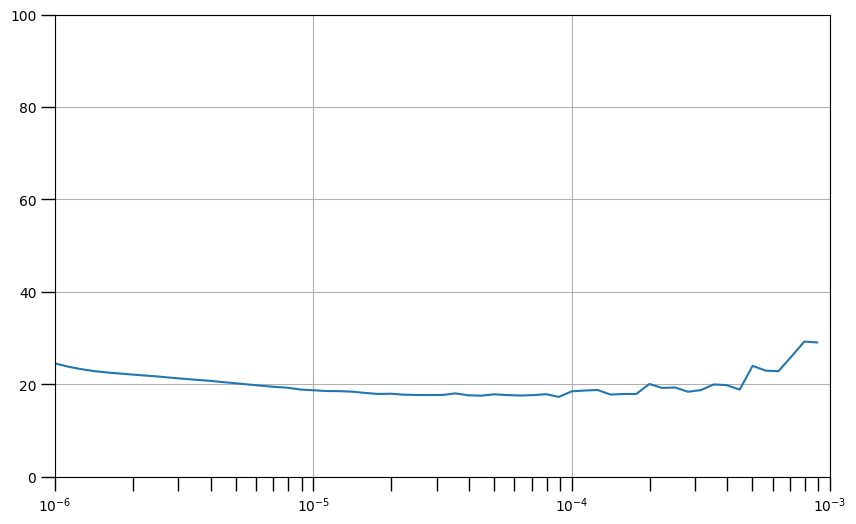

In [19]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-6, 1e-3, 0, 100])

## Train the Model

Once you've picked a learning rate, you can rebuild the model and start training.

In [20]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [21]:
# Set the learning rate
learning_rate = 2e-5

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 30.4662 - mae: 30.9614
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 20.2681 - mae: 20.7623
Epoch 3/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 18.4373 - mae: 18.9309

2024-07-11 15:37:52.903818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:53.007600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 18.6698 - mae: 19.1632
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 18.9546 - mae: 19.4475
Epoch 5/100
54/93 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 17.3211 - mae: 17.8148

2024-07-11 15:37:53.110361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:53.211910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 17.8397 - mae: 18.3332
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 17.6858 - mae: 18.1779
Epoch 7/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 17.6909 - mae: 18.1842

2024-07-11 15:37:53.314603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:53.417212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 17.6718 - mae: 18.1646
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 17.5617 - mae: 18.0545
Epoch 9/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 17.3068 - mae: 17.7979

2024-07-11 15:37:53.519618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:53.623767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 17.3347 - mae: 17.8260
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 17.8458 - mae: 18.3372
Epoch 11/100
50/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.1619 - mae: 17.6553 

2024-07-11 15:37:53.729496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:53.833408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 17.2652 - mae: 17.7579
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 17.2466 - mae: 17.7378
Epoch 13/100
54/93 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 16.9790 - mae: 17.4729

2024-07-11 15:37:53.940103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:54.043396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 17.0829 - mae: 17.5761
Epoch 14/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 16.8425 - mae: 17.3352
Epoch 15/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 18.5294 - mae: 19.0194

2024-07-11 15:37:54.145351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:54.248859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 18.1219 - mae: 18.6126
Epoch 16/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 17.3209 - mae: 17.8129
Epoch 17/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 16.5165 - mae: 17.0082

2024-07-11 15:37:54.351846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:54.454828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 16.7740 - mae: 17.2658
Epoch 18/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 16.7901 - mae: 17.2824
Epoch 19/100
52/93 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 16.7340 - mae: 17.2248

2024-07-11 15:37:54.559506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:54.661881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 16.7774 - mae: 17.2682
Epoch 20/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 16.5198 - mae: 17.0115
Epoch 21/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 16.7773 - mae: 17.2667

2024-07-11 15:37:54.762404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:54.866089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 16.9283 - mae: 17.4186
Epoch 22/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 16.5088 - mae: 16.9973
Epoch 23/100
31/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.9226 - mae: 18.4164 

2024-07-11 15:37:54.968631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:55.072535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.4026 - mae: 17.8956
Epoch 24/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 16.8834 - mae: 17.3745
Epoch 25/100
54/93 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 16.7109 - mae: 17.2030

2024-07-11 15:37:55.212007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:55.316910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 16.7935 - mae: 17.2857
Epoch 26/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 16.6284 - mae: 17.1194
Epoch 27/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 15.6455 - mae: 16.1365

2024-07-11 15:37:55.417545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:55.519906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 16.0970 - mae: 16.5884
Epoch 28/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 17.0491 - mae: 17.5403
Epoch 29/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 16.8513 - mae: 17.3423

2024-07-11 15:37:55.622616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:55.729583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 16.9112 - mae: 17.4021
Epoch 30/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 16.4348 - mae: 16.9247
Epoch 31/100
54/93 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 16.1737 - mae: 16.6651

2024-07-11 15:37:55.831705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:55.934420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 16.3530 - mae: 16.8440
Epoch 32/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 16.1964 - mae: 16.6877
Epoch 33/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 16.3420 - mae: 16.8347

2024-07-11 15:37:56.036416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:56.138957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 16.4676 - mae: 16.9598
Epoch 34/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 16.9889 - mae: 17.4824
Epoch 35/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 16.6078 - mae: 17.0989
Epoch 36/100


2024-07-11 15:37:56.241462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:56.344329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:56.437054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 16.9897 - mae: 17.4826
Epoch 37/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 17.1554 - mae: 17.6479
Epoch 38/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 17.6019 - mae: 18.0948
Epoch 39/100


2024-07-11 15:37:56.529312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:56.621560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:56.723696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 16.8927 - mae: 17.3828
Epoch 40/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 16.6068 - mae: 17.0957
Epoch 41/100
56/93 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 17.9546 - mae: 18.4452

2024-07-11 15:37:56.828487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:56.929848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:57.030245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 17.5530 - mae: 18.0437
Epoch 42/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 16.5218 - mae: 17.0139
Epoch 43/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 17.0573 - mae: 17.5494
Epoch 44/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 16.3305 - mae: 16.8227

2024-07-11 15:37:57.139136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:57.247468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 16.5952 - mae: 17.0866
Epoch 45/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 16.7796 - mae: 17.2718
Epoch 46/100
54/93 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 16.8035 - mae: 17.2963

2024-07-11 15:37:57.349650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:57.451599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 16.7288 - mae: 17.2209
Epoch 47/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 16.4740 - mae: 16.9662
Epoch 48/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 16.9684 - mae: 17.4595

2024-07-11 15:37:57.553821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:57.659192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 16.9804 - mae: 17.4711
Epoch 49/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 16.7183 - mae: 17.2091
Epoch 50/100
52/93 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 16.7975 - mae: 17.2900

2024-07-11 15:37:57.762194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:57.866615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 16.7432 - mae: 17.2353
Epoch 51/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 17.0696 - mae: 17.5618
Epoch 52/100
52/93 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 16.8392 - mae: 17.3293

2024-07-11 15:37:57.969740: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:58.072122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 16.7840 - mae: 17.2744
Epoch 53/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 16.5743 - mae: 17.0649
Epoch 54/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.7264 - mae: 18.2155 

2024-07-11 15:37:58.175858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:58.278040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8121 - mae: 17.3034
Epoch 55/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - loss: 17.9158 - mae: 18.4050
Epoch 56/100
52/93 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 16.2982 - mae: 16.7862

2024-07-11 15:37:58.418685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:58.519856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 16.4701 - mae: 16.9590
Epoch 57/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 17.0845 - mae: 17.5746
Epoch 58/100
54/93 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 16.3321 - mae: 16.8216

2024-07-11 15:37:58.624001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:58.727861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 16.4192 - mae: 16.9093
Epoch 59/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 16.8654 - mae: 17.3564
Epoch 60/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 16.5929 - mae: 17.0843

2024-07-11 15:37:58.830037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:58.934514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 16.6611 - mae: 17.1522
Epoch 61/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 16.5861 - mae: 17.0772
Epoch 62/100
52/93 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 16.9234 - mae: 17.4144

2024-07-11 15:37:59.037534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:59.142384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 16.9280 - mae: 17.4197
Epoch 63/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 16.9853 - mae: 17.4780
Epoch 64/100
52/93 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 15.5758 - mae: 16.0689

2024-07-11 15:37:59.245890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:59.348894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 15.9500 - mae: 16.4428
Epoch 65/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 17.1395 - mae: 17.6304
Epoch 66/100
51/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.0960 - mae: 17.5885 

2024-07-11 15:37:59.452791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:59.556099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 17.0192 - mae: 17.5109
Epoch 67/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 16.1904 - mae: 16.6803
Epoch 68/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 17.4513 - mae: 17.9447

2024-07-11 15:37:59.660159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:59.762077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 17.1530 - mae: 17.6459
Epoch 69/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 16.4448 - mae: 16.9365
Epoch 70/100
56/93 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 17.4101 - mae: 17.9016

2024-07-11 15:37:59.864947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:37:59.966159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:38:00.065859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 17.1573 - mae: 17.6487
Epoch 71/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 16.4963 - mae: 16.9870
Epoch 72/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 16.9114 - mae: 17.4031
Epoch 73/100
51/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.2867 - mae: 16.7791 

2024-07-11 15:38:00.168833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:38:00.273602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 16.4626 - mae: 16.9546
Epoch 74/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 16.7526 - mae: 17.2435
Epoch 75/100
54/93 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 16.7957 - mae: 17.2880

2024-07-11 15:38:00.377878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:38:00.480969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 16.9170 - mae: 17.4090
Epoch 76/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 16.7074 - mae: 17.2001
Epoch 77/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 16.2702 - mae: 16.7637

2024-07-11 15:38:00.582787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:38:00.687017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 16.4722 - mae: 16.9651
Epoch 78/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 16.5740 - mae: 17.0650
Epoch 79/100
52/93 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 16.6923 - mae: 17.1822

2024-07-11 15:38:00.789554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:38:00.893089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 16.7474 - mae: 17.2376
Epoch 80/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 16.7187 - mae: 17.2106
Epoch 81/100
52/93 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 15.9968 - mae: 16.4862

2024-07-11 15:38:00.996073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:38:01.101764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 16.2380 - mae: 16.7278
Epoch 82/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 16.6906 - mae: 17.1807
Epoch 83/100
51/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15.7721 - mae: 16.2634 

2024-07-11 15:38:01.204869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:38:01.309084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 16.1119 - mae: 16.6034
Epoch 84/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 16.3693 - mae: 16.8614
Epoch 85/100
52/93 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 16.5817 - mae: 17.0745

2024-07-11 15:38:01.414417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:38:01.517526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 16.6251 - mae: 17.1174
Epoch 86/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 16.4364 - mae: 16.9270
Epoch 87/100
51/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15.8263 - mae: 16.3196 

2024-07-11 15:38:01.621398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:38:01.724092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 16.1007 - mae: 16.5930
Epoch 88/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 16.3658 - mae: 16.8579
Epoch 89/100
51/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4711 - mae: 16.9630 

2024-07-11 15:38:01.829882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:38:01.935525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 16.5123 - mae: 17.0040
Epoch 90/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 16.3167 - mae: 16.8096
Epoch 91/100
52/93 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 16.1537 - mae: 16.6433

2024-07-11 15:38:02.039813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:38:02.144905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 16.4189 - mae: 16.9093
Epoch 92/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 16.9842 - mae: 17.4734
Epoch 93/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 16.7781 - mae: 17.2683

2024-07-11 15:38:02.251432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:38:02.353309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 16.6688 - mae: 17.1591
Epoch 94/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 16.4098 - mae: 16.8993
Epoch 95/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 16.6195 - mae: 17.1109

2024-07-11 15:38:02.455291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:38:02.558127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 16.6121 - mae: 17.1031
Epoch 96/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 16.5458 - mae: 17.0353
Epoch 97/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 16.4868 - mae: 16.9800

2024-07-11 15:38:02.661161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:38:02.764581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 16.4731 - mae: 16.9653
Epoch 98/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 16.5444 - mae: 17.0363
Epoch 99/100
52/93 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 16.3381 - mae: 16.8287

2024-07-11 15:38:02.867437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:38:02.970378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 16.4982 - mae: 16.9891
Epoch 100/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 16.0891 - mae: 16.5810


2024-07-11 15:38:03.074880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-11 15:38:03.177634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


## Model Prediction

Now see if the model generates good results. If you used the default parameters of this notebook, you should see the predictions follow the shape of the ground truth with an MAE of around 15. 

In [22]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2024-07-11 15:40:43.463800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


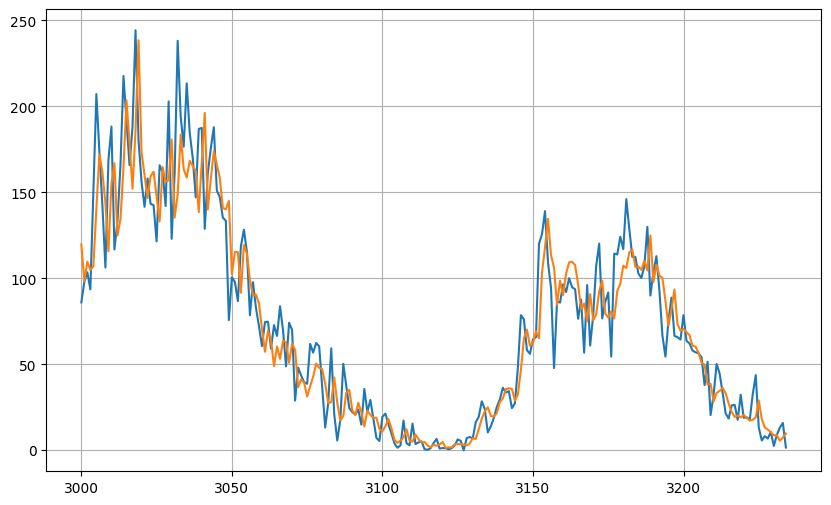

In [23]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [24]:
# Compute the MAE
print(tf.keras.metrics.mae(x_valid, results).numpy())

14.586441


## Wrap Up

In this lab, you built a relatively simple DNN to forecast sunspot numbers for a given month. We encourage you to tweak the parameters or train longer and see the best results you can get. In the next lab, you will build a more complex model and you evaluate if the added complexity translates to better or worse results.